## Score Predictor
Importing all relevant libraries for Data Preparation (importing and cleaning), EDA, ML Model Implementation and Results Evaluation.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set()
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload 
%autoreload 2

Firstly, we read the dataset into a dataframe using pandas.


In [4]:
df = pd.read_csv('odi.txt')
df.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2006-06-13,"Civil Service Cricket Club, Stormont",England,Ireland,ME Trescothick,DT Johnston,0,0,0.1,0,0,0,0,301
1,1,2006-06-13,"Civil Service Cricket Club, Stormont",England,Ireland,ME Trescothick,DT Johnston,0,0,0.2,0,0,0,0,301
2,1,2006-06-13,"Civil Service Cricket Club, Stormont",England,Ireland,ME Trescothick,DT Johnston,4,0,0.3,4,0,0,0,301
3,1,2006-06-13,"Civil Service Cricket Club, Stormont",England,Ireland,ME Trescothick,DT Johnston,6,0,0.4,6,0,0,0,301
4,1,2006-06-13,"Civil Service Cricket Club, Stormont",England,Ireland,ME Trescothick,DT Johnston,6,0,0.5,6,0,0,0,301


A concise summary of the dataframe is given below. It shows that there a total of 15 non-null columns. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350899 entries, 0 to 350898
Data columns (total 15 columns):
mid               350899 non-null int64
date              350899 non-null object
venue             350899 non-null object
bat_team          350899 non-null object
bowl_team         350899 non-null object
batsman           350899 non-null object
bowler            350899 non-null object
runs              350899 non-null int64
wickets           350899 non-null int64
overs             350899 non-null float64
runs_last_5       350899 non-null int64
wickets_last_5    350899 non-null int64
striker           350899 non-null int64
non-striker       350899 non-null int64
total             350899 non-null int64
dtypes: float64(1), int64(8), object(6)
memory usage: 40.2+ MB


In [6]:
#reading all numeric features into X as numpy array
X = np.asarray(df[[u'runs', u'wickets', u'overs', u'runs_last_5', u'wickets_last_5',
       u'striker', u'non-striker']].dropna())

#scaling features to avoid dominance of attributes with higher magnitude
X_scaled = scale(X)

#reading target feature in Y
Y = df['total'].values

Before proceeding for actual model implementation, we just check which features are more important.

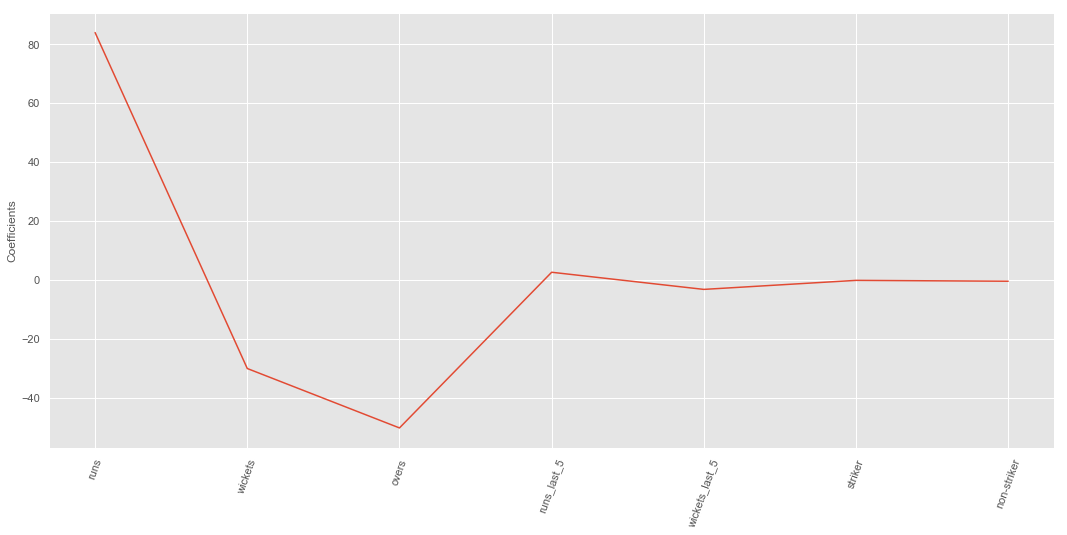

In [7]:
# using lasso for feature selection
names = df[[u'runs', u'wickets', u'overs', u'runs_last_5', u'wickets_last_5',
       u'striker', u'non-striker']].columns

lasso = Lasso(alpha=0.001)
lasso_coef = lasso.fit(X_scaled, Y).coef_

plt.figure(figsize=(18,8))
_ = plt.plot(range(len(names)), lasso_coef) 
_ = plt.xticks(range(len(names)), names, rotation=70) 
_ = plt.ylabel('Coefficients') 
plt.show()

As Lasso zero down all unimportant features, we can see from above graph that 'runs', 'runs_last_5', 'striker' and 'non-striker' are the most significant feature here. Let us just fit our model on these 4 features.

## Random Forest

In [8]:
X_new = np.asarray(df[[u'runs', u'runs_last_5', u'striker', u'non-striker']].dropna())
X_new = scale(X_new)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_new, Y, test_size=0.25, random_state=5)
rfr = RandomForestRegressor(random_state=5)
rfr.fit(Xtrain, Ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [9]:
def custom_accuracy(y_test, y_pred, threshold):
    right = 0

    l = len(y_pred)
    for i in range(0,l):
        if(abs(y_pred[i]-y_test[i]) <= threshold):
            right += 1
    return ((right/l)*100)

y_pred = rfr.predict(Xtest)
print('Mean Absolute Error: ', mean_absolute_error(Ytest, y_pred))
print('Accuracy: ', custom_accuracy(Ytest, y_pred, 25))

Mean Absolute Error:  25.43182709570694
Accuracy:  64.51752636078655


## Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
y_pred = lr.predict(Xtest)
print('Mean Absolute Error: ', mean_absolute_error(Ytest, y_pred))
print('Accuracy: ', custom_accuracy(Ytest, y_pred, 25))

Mean Absolute Error:  43.35958465155671
Accuracy:  36.69991450555714
